Keyword
=====
 * Triplet Semi-Hard Loss Function  
 * Convolutional Neural Network (DenseNet-121 / Inception-V3)  
 * Rectified Adam Optimizer / Lookahead Optimizer Wrapper  
 * 5-Fold Cross Validation  
      * Repeat 5-times (total 25 sub-models)  

Default Setting
====
Tensorflow 관련 모듈을 추가하고, Google Drive 및 Google Cloud Platform 저장소 사용을 위한 코드입니다.  

모든 모듈을 서두에 import 하지는 않았으며, (습관상) 필요할 때 마다 추가하였습니다.

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa #pip install tensorflow-addons
import tensorflow_datasets as tfds #pip install tensorflow-datasets

In [2]:
print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")
print(f"tfds.__version__: {tfds.__version__}")

tf.__version__: 2.4.1
tfa.__version__: 0.12.1
tfds.__version__: 4.2.0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17787751061228655928
]


In [4]:
# OS
import platform
platform.platform()

'Windows-10-10.0.19041-SP0'

In [5]:
import numpy as np
import pandas as pd

import os
NOTEBOOKNAME = "try115"

Generate Dataset
====

데이터 세트를 Train / Validation으로 분할합니다.  

신경망의 주입값으로 사용하기 위한 적절한 전처리 과정들이 나열되어 있습니다.  

train dataset을 생성하되, SEED를 기반으로 섞어줍니다.

In [6]:
from sklearn.utils import shuffle

def get_tr_data(SEED):    
    tr_data = pd.read_csv("train.csv", index_col = 0).values
    tr_data = shuffle(tr_data, random_state = SEED)

    tr_X = tf.convert_to_tensor(tr_data[:, 2:], dtype = tf.float32) #데이터 타입 텐서로 변환
    tr_Y = tf.squeeze(tf.convert_to_tensor(tr_data[:, 0], dtype = tf.int32)) #데이터 차원에서 1인 부분 제거 (3,1)->(3,)

    return tr_X, tr_Y


def get_ts_data():
    ts_data = pd.read_csv("est.csv", index_col = 0).values
    ts_X = tf.convert_to_tensor(ts_data[:, 1:], dtype = tf.float32)

    return ts_X

(784) 사이즈의 flatten tensor를 (28, 28) 사이즈의 이미지로 변환한 뒤, (256, 256) 사이즈로 upsampling 합니다.

이후 값을 구간 [0, 1]로 맞추는 Normalize를 진행하여 줍니다.

아래 정의된 두 함수의 차이는 단순히 label의 유무입니다.

In [7]:
IMAGE_SIZE = [28, 28]
RESIZED_IMAGE_SIZE = [256, 256]

@tf.function
def _reshape_and_resize_tr(flatten_tensor, label):
    image_tensor = tf.reshape(flatten_tensor, (*IMAGE_SIZE, 1))
    image_tensor = tf.keras.layers.experimental.preprocessing.Resizing(*RESIZED_IMAGE_SIZE)(image_tensor)
    image_tensor = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image_tensor)
    return image_tensor, label


@tf.function
def _reshape_and_resize_ts(flatten_tensor): # without label
    image_tensor = tf.reshape(flatten_tensor, (*IMAGE_SIZE, 1))
    image_tensor = tf.keras.layers.experimental.preprocessing.Resizing(*RESIZED_IMAGE_SIZE)(image_tensor)
    image_tensor = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image_tensor)
    return image_tensor

```
tf.reshape(
    tensor, shape, name=None
)

tf.keras.layers.experimental.preprocessing.Resizing(
    height, width, interpolation='bilinear', name=None, **kwargs
)

tf.keras.layers.experimental.preprocessing.Rescaling(
    scale, offset=0.0, name=None, **kwargs
)
```
**To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.**

make_dataset() 함수는 단순히 type에 따라 적절한 데이터 세트를 생성하는 기능을 수행합니다.

make_fold() 함수는 5개의 dataset으로 이루어진 tr_datasets, vl_datasets를 반환합니다.

The make_dataset() function simply performs the function of creating an appropriate data set according to the type.

The make_fold() function returns tr_datasets and vl_datasets consisting of 5 datasets.

**tf.data.experimental.AUTOTUNE**  
모델과 파이프라인의 유휴 시간을 조절하기 위한 값을 자동으로 조정해줘 프로그램의 전반적인 속도향상을 올려줌.

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 #2048/64 =32

def print_shapes(l, l_name, end = False):
    assert type(l) is list

    print(f"len({l_name}) = {len(l)}")
    for i in range(len(l)):
        print(f"{l_name}[{i}]: {l[i]}")
    if not end:
        print()
    

def make_dataset(X, Y, type):
    if type == "train":
        assert X.shape[0] == Y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((X, Y)
                            ).map(_reshape_and_resize_tr, num_parallel_calls = AUTO
                            ).cache(
                            ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)   

    elif type == "validation":
        assert X.shape[0] == Y.shape[0]
        dataset = tf.data.Dataset.from_tensor_slices((X, Y)
                            ).map(_reshape_and_resize_tr, num_parallel_calls = AUTO
                            ).cache(
                            # ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)

    elif type == "test":
        assert Y is None
        dataset = tf.data.Dataset.from_tensor_slices((X)
                            ).map(_reshape_and_resize_ts, num_parallel_calls = AUTO
                            ).cache(
                            # ).shuffle(20000, reshuffle_each_iteration = True
                            ).batch(BATCH_SIZE
                            ).prefetch(AUTO)
                            
    else:
        raise ValueError(f"Unknown type: {type}")

    return dataset


def make_fold(X, Y, K = 5):
    assert X.shape[0] == Y.shape[0]
    assert len(list(Y.shape)) == 1

    fold_size = [X.shape[0] // K] * (K - 1) + [X.shape[0] - (X.shape[0] // K) * (K - 1)]

    splited_X = tf.split(X, fold_size, 0) # list
    splited_Y = tf.split(Y, fold_size, 0) # list

    tr_list = [(tf.concat(splited_X[:i] + splited_X[i+1:], axis = 0), tf.concat(splited_Y[:i] + splited_Y[i+1:], axis = 0)) for i in range(K)]
    vl_list = [(splited_X[i], splited_Y[i]) for i in range(K)]

    tr_datasets = [make_dataset(tr_X, tr_Y, "train") for tr_X, tr_Y in tr_list]
    vl_datasets = [make_dataset(vl_X, vl_Y, "validation") for vl_X, vl_Y in vl_list]

    return tr_datasets, vl_datasets

```
tf.split(
    value, num_or_size_splits, axis=0, num=None, name='split'
)
```

Show Examples  
====
Upsampling 및 Augmentation 간 사용한 매개변수의 근거가 되는 라인입니다.  

(28, 28) 사이즈의 원본 이미지를 (64, 64), (128, 128), (256, 256) 사이즈로 해상도를 높였을 때 에러없이 잘 수행되는지 확인합니다.  

눈으로 보았을 때 이상이 없으므로, (256, 256) 사이즈로 해상도를 높여도 문제가 없을 것 같습니다.  

In [9]:
tr_data = pd.read_csv("train.csv", index_col = 0).values
# tr_data = shuffle(tr_data, random_state = SEED)

tr_X = tf.convert_to_tensor(tr_data[:, 2:], dtype = tf.float32)
tr_Y = tf.squeeze(tf.convert_to_tensor(tr_data[:, 0], dtype = tf.int32))

tr_data[318,1]

'B'

In [10]:
aa = tf.reshape(tr_X[318], (28, 28, 1))
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

answer = tr_Y[318]

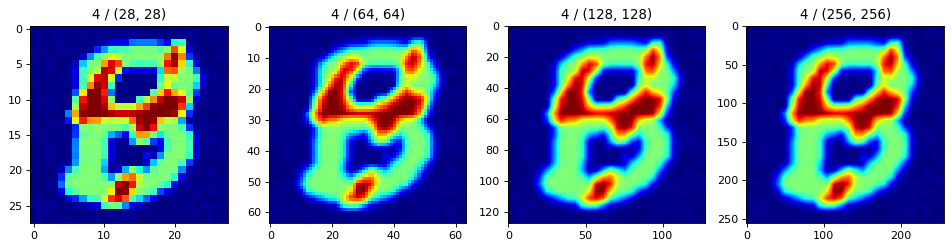

In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(img), cmap = "jet")
    plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()

저는 데이터 증식은 무작정 데이터의 수를 늘리기만 해서는 되는것이 아니라, 해당 데이터가 갖는 중요한 정보를 잃지 않는 것이 가장 중요하다고 생각했습니다.

따라서 전체 데이터를 더해주었을 때, 그 값이 높은 부분(적색 부분)이 최대한 손상되지 않는 범위에서 zooming, shifting 및 rotating 등의 작업을 수행하는 것이 바람직한 접근방법일 것입니다.  

먼저 training dataset을 다 더해준 값을 확인해줍니다.

In [12]:
aa = tf.reshape(tr_X, (-1, 28, 28, 1))
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

aa.shape

TensorShape([2048, 28, 28, 1])

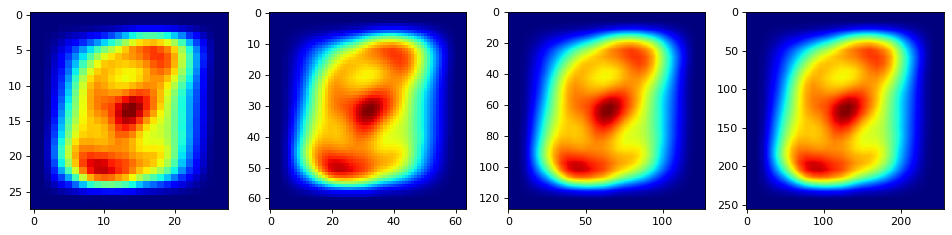

In [13]:
plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(tf.math.reduce_sum(img, axis = 0)), cmap = "jet")
    # plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()

Test dataset 또한 확인해줍니다.

Also check the test dataset.

In [14]:
ts_data = pd.read_csv("test.csv", index_col = 0).values
ts_X = tf.convert_to_tensor(ts_data[:, 1:], dtype = tf.float32)

In [15]:
aa = tf.reshape(ts_X, (-1, 28, 28, 1))
result1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(aa)
result2 = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(aa)
result3 = tf.keras.layers.experimental.preprocessing.Resizing(256, 256)(aa)

# answer = tr_Y
aa.shape

TensorShape([20480, 28, 28, 1])

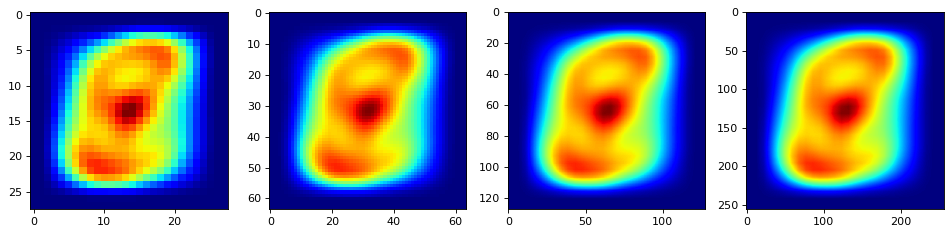

In [16]:
plt.figure(figsize = (12, 4), dpi = 80)

for i, img in enumerate([aa, result1, result2, result3]):
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(tf.squeeze(tf.math.reduce_sum(img, axis = 0)), cmap = "jet")
    # plt.title(f"{answer} / {tf.squeeze(img).shape}")
    
plt.tight_layout()
plt.show()

저는 데이터 증식에는 회전 및 확대/축소만 수행했습니다.

위의 실험 결과에 따라, 확대 범위는 매우 낮은 값인 0.1로 설정하게 되었습니다.

Build Model
====

신경망 구성 단계입니다.

직접 구현한 DenseNet-121 구조를 사용했으며, SpatialDropout 및 InceptionV3에서 사용되는 auxiliary output를 추가했습니다.

Auxiliary output으로부터 auxiliary loss가 생성되며, 이는 0.2의 가중치가 곱해져서 최종 loss에 가산됩니다.

테스트 단계에서는 해당 output이 사용되지 않습니다.

신경망 1개당 약 8.3M 개의 파라미터를 가집니다.

다른 유저분들과는 다르게, 저는 Softmax + Categorical Crossentropy 구조를 사용하지 않았습니다.

대신 activation function이 없는 dense를 거친 output을 L2 정규화하여 내보낸 뒤, Triplet Semi-Hard Loss Function을 이용하여 손실을 계산했습니다.

Triplet Loss Function은 3개의 feature를 비교하는 방식으로, anchor(기준 특징값)와 positive class (같은 클래스의 특징값) 사이의 거리는 가깝게 매핑합니다. 이와 동시에, anchor와 negative class (다른 클래스의 특징값) 사이의 거리는 멀게 매핑합니다.

Image에 대한 Embedding 기법이라고 생각하시면 좋을 것 같습니다.

해당 손실함수에 대한 추가적인 내용은 아래를 참고하여 주시기 바랍니다.

 * https://www.tensorflow.org/addons/tutorials/losses_triplet
 * https://arxiv.org/pdf/1503.03832.pdf
 * https://jsideas.net/ImageEmbeddingWithTripletLoss/
 
 해당 손실함수와 auxiliary loss를 사용할 경우, 손실 그래프는 대략 아래와 같이 표현됩니다.

![결과예시](Triplet-Loss.png)

특별히 해당 loss를 사용하는 이유는, 성능이 좋을 것을 확신해서가 아닙니다.

단지 기존에 주류를 이루는 방법과는 다른 저만의 방식으로도 충분히 좋은 성과를 낼 수 있음을 입증하기 위한 새로운 시도였습니다.

In [17]:
def bn_ReLU_conv2D(x, filters, kernel_size, 
                   strides = 1, padding = "same", weight_decay = 1e-4):
    x = tf.keras.layers.BatchNormalization()(x) #gradient vanishing or exploding 방지!
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(
        filters = filters, 
        kernel_size = kernel_size, 
        strides = strides,
        padding = padding,
        kernel_regularizer = tf.keras.regularizers.l2(weight_decay))(x)
    
    return x


def transition_block(x):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(x.shape[-1] // 2, 1, padding = "same")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), strides = 2)(x) ##pooling layer 

    return x


def dense_block(x, num_conv, growth_rate):
    for i in range(num_conv):
        residual = x
        x = bn_ReLU_conv2D(x, 4 * growth_rate, 1)
        x = bn_ReLU_conv2D(x, growth_rate, 3)
        x = tf.keras.layers.Concatenate(axis = -1)([x, residual])

    return x

![L2 Norm](L2_norm.png)

```
tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None,
    renorm=False, renorm_clipping=None, renorm_momentum=0.99, fused=None,
    trainable=True, virtual_batch_size=None, adjustment=None, name=None, **kwargs
)

tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), strides=None, padding='valid', data_format=None,
    **kwargs
)
```

In [18]:
def create_NN(model_name, dropout_rate = 0.3, growth_rate = 32):
    model_input = tf.keras.layers.Input((*RESIZED_IMAGE_SIZE, 1))

    ## Pre-processing
    x = tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.1), (-0.2, 0.1), fill_mode = "constant")(model_input)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode = "constant")(x)

    ## Entry Flow
    x = tf.keras.layers.Conv2D(2 * growth_rate, 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides = 2, padding = "same")(x)


    ## Middle Flow
    aux_outputs = []
    for i, num_conv in enumerate([6, 12, 24, 16]):
        x = dense_block(x, num_conv, growth_rate)

        if i != 3: 
            x = transition_block(x)
            x = tf.keras.layers.SpatialDropout2D(dropout_rate)(x)

        if i == 2:
            y = tf.keras.layers.GlobalAveragePooling2D()(x)
            y = tf.keras.layers.Dense(y.shape[-1])(y)
            y = tf.keras.layers.Lambda(lambda y: tf.math.l2_normalize(y, axis = 1), name = "aux")(y) # L2 normalize embeddings
            aux_outputs.append(y)


    ## Exit Flow
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(x.shape[-1])(x)
    real_output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis = 1), name = "real")(x) # L2 normalize embeddings

    model = tf.keras.Model(
        inputs = model_input,
        outputs = aux_outputs + [real_output],
        name = model_name)
    
    return model

In [19]:
tmp_model = create_NN("tmp_model")
tmp_model.summary()

Model: "tmp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
random_zoom (RandomZoom)        (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 256, 256, 1)  0           random_zoom[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3200        random_rotation[0][0]            
__________________________________________________________________________________________

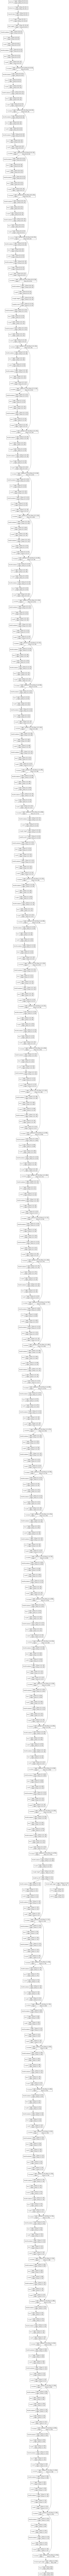

In [20]:
tf.keras.utils.plot_model(tmp_model, show_shapes = True, show_layer_names = False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')

In [21]:
del tmp_model

Compile and Train
====

매번 새로운 옵티마이저, 콜백 함수를 호출하기 위해서 함수로 구현한 부분입니다.

optimizer 함수는 Rectified Adam을 사용했으며, Lookahead Wrapper를 추가해주었습니다.

특별히 Lookahead Wrapper는 "월간 데이콘 5: 생체 광학 데이터 분석 AI 경진대회"에서 1위를 수상하신 SF 님께서도 사용하셨기 때문에, 관심을 갖고 찾아보고 실험하였습니다.

https://dacon.io/competitions/official/235608/codeshare/1274?page=2&dtype=recent&ptype=pub

Droout Rate, Growth Rate, Optimizer는 각각 0.3, 32, Rectified Adam을 사용하였으며, 해당 근거는 아래 표와 같습니다.


(growth_rate == 40일 경우는 ResourceExhauseError 때문에 수행하지 못했습니다.)


1. Dropout = 0.3

|growth_rate|optimizer|val_loss|
|:---:|:---:|:---|
|12|Adam|0.38935| 
|12|AdamW|0.34652| 
|12|Rectified Adam|0.35595| 
|12|RMSprop|0.55919| 
|24|Adam|0.37023| 
|24|AdamW|0.36667| 
|24|Rectified Adam|0.31322| 
|24|RMSprop|0.46081| 
|32|Adam|0.46318| 
|32|AdamW|0.31881| 
|32|Rectified Adam|0.31315| 
|32|RMSprop|0.43235|
  
2. Dropout = 0.4  

|growth_rate|optimizer|val_loss|
|:---:|:---:|:---|
|12|Adam|0.35099| 
|12|AdamW|0.45077|
|12|Rectified Adam|0.37492| 
|12|RMSprop|0.46896| 
|24|Adam|0.45740| 
|24|AdamW|0.34025| 
|24|Rectified Adam|0.31850| 
|24|RMSprop|0.43569| 
|32|Adam|0.43407| 
|32|AdamW|0.33302| 
|32|Rectified Adam|0.33354| 
|32|RMSprop|0.44503| 
  
3. Dropout = 0.5  

|growth_rate|optimizer|val_loss|
|:---:|:---:|:---|
|12|Adam|0.51993|  
|12|AdamW|0.49499|  
|12|Rectified Adam|0.39148|  
|12|RMSprop	0.62542|  
|24|Adam|0.43550|  
|24|AdamW|0.36983|  
|24|Rectified Adam|0.31850|  
|24|RMSprop|0.58344|  
|32|Adam|0.40553|  
|32|AdamW|0.41680|  
|32|Rectified Adam|0.37814|  
|32|RMSprop	0.51033|  

가장 성능이 좋았던 모델은, (dropout_rate, growth_rate, optimizer)가 (0.3, 32, Rectified Adam)일 경우였으며, 해당 인자를 그대로 사용했습니다.


In [22]:
def get_opt(init_lr = 3e-3):
    radam = tfa.optimizers.RectifiedAdam(
        lr = init_lr, warmup_proportion = 0, min_lr = 1e-5, weight_decay = 1e-4)
    ranger = tfa.optimizers.Lookahead(radam)

    return ranger

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

def draw_history(history):
    plt.figure(figsize = (8, 6), facecolor = "white", dpi = 80)

    plt.plot(history.epoch, history.history["aux_loss"], "rx-", label = "aux_loss", alpha = 0.5)
    plt.plot(history.epoch, history.history["val_aux_loss"], "bx-", label = "val_aux_loss", alpha = 0.5)
    plt.plot(history.epoch, history.history["real_loss"], "ro-", label = "real_loss")
    plt.plot(history.epoch, history.history["val_real_loss"], "bo-", label = "val_real_loss")

    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

5-Fold Cross Validation을 수행하되, SEED에 따라 dataset을 섞음으로써 매번 다른 train / validation 쌍이 나올 수 있도록 합니다.

총 5번 반복하였으므로, 25개의 sub-model이 생성됩니다.

코드 실행결과는 너무 길어서 생략하였습니다.

Perform 5-Fold Cross Validation, but mix the dataset according to SEED so that different train/validation pairs can appear each time.

Since it was repeated 5 times, 25 sub-models are created.

The code execution result was too long to be omitted.

Try 0: N = 0, SEED = 1234
====

In [24]:
tr_X, tr_Y = get_tr_data(SEED = 1234)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

tr_X.shape: (2048, 784), dtype: <dtype: 'float32'>
tr_Y.shape: (2048,), dtype: <dtype: 'int32'>


In [25]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

len(tr_datasets) = 5
tr_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[4]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

len(vl_datasets) = 5
vl_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[4]: <Pref

In [34]:
N = 0
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

Epoch 1/400


KeyboardInterrupt: 

In [ ]:
draw_history(histories)

Try 1: N = 1, SEED = 2345
====

In [26]:
tr_X, tr_Y = get_tr_data(SEED = 2345)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

tr_X.shape: (2048, 784), dtype: <dtype: 'float32'>
tr_Y.shape: (2048,), dtype: <dtype: 'int32'>


In [27]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

len(tr_datasets) = 5
tr_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[4]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

len(vl_datasets) = 5
vl_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[4]: <Pref

In [ ]:
N = 1
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
draw_history(histories)

Try 2: N = 2, SEED = 3456
====

In [28]:
tr_X, tr_Y = get_tr_data(SEED = 3456)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

tr_X.shape: (2048, 784), dtype: <dtype: 'float32'>
tr_Y.shape: (2048,), dtype: <dtype: 'int32'>


In [29]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

len(tr_datasets) = 5
tr_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[4]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

len(vl_datasets) = 5
vl_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[4]: <Pref

In [ ]:
N = 2
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
draw_history(histories)

Try 3: N = 3, SEED = 4567
====

In [30]:
tr_X, tr_Y = get_tr_data(SEED = 4567)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

tr_X.shape: (2048, 784), dtype: <dtype: 'float32'>
tr_Y.shape: (2048,), dtype: <dtype: 'int32'>


In [31]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

len(tr_datasets) = 5
tr_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[4]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

len(vl_datasets) = 5
vl_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[4]: <Pref

In [ ]:
N = 3
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
for history in histories:
    draw_history(history)

Try 4: N = 4, SEED = 5678
====

In [32]:
tr_X, tr_Y = get_tr_data(SEED = 5678)

print(f"tr_X.shape: {tr_X.shape}, dtype: {tr_X.dtype}")
print(f"tr_Y.shape: {tr_Y.shape}, dtype: {tr_Y.dtype}")

tr_X.shape: (2048, 784), dtype: <dtype: 'float32'>
tr_Y.shape: (2048,), dtype: <dtype: 'int32'>


In [33]:
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Print the shapes.
print_shapes(tr_datasets, "tr_datasets")
print_shapes(vl_datasets, "vl_datasets", end = True)

len(tr_datasets) = 5
tr_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
tr_datasets[4]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>

len(vl_datasets) = 5
vl_datasets[0]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[1]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[2]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[3]: <PrefetchDataset shapes: ((None, 256, 256, 1), (None,)), types: (tf.float32, tf.int32)>
vl_datasets[4]: <Pref

In [ ]:
N = 4
K = 5
GCS_PATH = "gs://dacon-7-emnist"

histories = []
for fold in range(K):
    model = create_NN(f"model_{N}_{fold}")

    model.compile(
        optimizer = get_opt(),
        loss = tfa.losses.TripletSemiHardLoss(),
        loss_weights = [0.2, 1.0])
    
    history = model.fit(
        tr_datasets[fold], validation_data = vl_datasets[fold], epochs = 400, verbose = 2,
        callbacks = get_callbacks(GCS_PATH, model.name))

    histories.append(history)
    
    del model

In [ ]:
for history in histories:
    draw_history(history)

Load Latest Models
====
생성된 25개의 sub-model을 호출합니다.

Call the created 25 sub-models.

In [ ]:
%%time
num_N = 5
K = 5
GCS_PATH = "gs://dacon-7-emnist"

models = []

for n in range(num_N):
    for fold in range(K):
        model = create_NN(f"model_{n}_{fold}")

        checkpoint_dir = os.path.join(GCS_PATH, "ckpt", NOTEBOOKNAME, model.name)
        latest = tf.train.latest_checkpoint(checkpoint_dir)

        model.load_weights(latest)
        models.append(model)
        
        print(f"Try #{n}, Fold #{fold}: {latest}")

Generate Enrollment Templates
====
각 신경망에 대한 validation dataset의 output을 산출합니다.

해당 결괏값들의 클래스별 평균이 곧 해당 클래스를 대표하는 "대표값(enrollment template)"이 됩니다.

앞서 모델 생성 간, auxiliary output을 추가하였다고 말씀드렸습니다. 실제로 모델 output을 받을 경우에는, 길이 512짜리 aux output과 1024짜리 real output이 리스트(list)에 담겨서 나옵니다. 우리가 원하는 값은 real output이므로, 2번째 값만 사용합니다.

Calculate the output of the validation dataset for each neural network.

The average of the result values by class becomes the "enrollment template" representing the class.

I mentioned earlier that during model creation, auxiliary outputs were added. In case of receiving model output, aux output of length 512 and real output of 1024 are included in the list. The value we want is a real output, so we only use the second value.

In [ ]:
# Example Code
tr_X, tr_Y = get_tr_data(1234)
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

aux, real = models[0].predict(vl_datasets[0])
print(f"aux_shape: {aux.shape}")
print(f"real_shape: {real.shape}")

aux_shape: (409, 512)  
real_shape: (409, 1024)

In [ ]:
%%time
results = []
seeds = [1234, 2345, 3456, 4567, 5678]

for n in range(num_N):
    tr_X, tr_Y = get_tr_data(SEED = seeds[n])
    tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

    for fold in range(K):
        result = models[n * 5 + fold].predict(vl_datasets[fold])[-1]
        results.append(result)

        print(f"results[{n * 5 + fold}].shape: {result.shape}")

results[0].shape: (409, 1024)  
results[1].shape: (409, 1024)  
results[2].shape: (409, 1024)  
results[3].shape: (409, 1024)  
results[4].shape: (412, 1024)  
results[5].shape: (409, 1024)  
results[6].shape: (409, 1024)  
results[7].shape: (409, 1024)  
results[8].shape: (409, 1024)  
results[9].shape: (412, 1024)  
results[10].shape: (409, 1024)  
results[11].shape: (409, 1024)  
results[12].shape: (409, 1024)  
results[13].shape: (409, 1024)  
results[14].shape: (412, 1024)  
results[15].shape: (409, 1024)  
results[16].shape: (409, 1024)  
results[17].shape: (409, 1024)  
results[18].shape: (409, 1024)  
results[19].shape: (412, 1024)  
results[20].shape: (409, 1024)  
results[21].shape: (409, 1024)  
results[22].shape: (409, 1024)  
results[23].shape: (409, 1024)  
results[24].shape: (412, 1024)  
CPU times: user 1min 4s, sys: 6.  21 s, total: 1min 10s
Wall time: 1min 7s  

Embedding Visualization
====
U-Map으로 Embedding한 결과를 보여줍니다.

It shows the result of Embedding with U-Map.

In [ ]:
# Example Code
import io
import numpy as np

tr_X, tr_Y = get_tr_data(1234)
tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

# Save test embeddings for visualization in projector
# https://projector.tensorflow.org/
np.savetxt("vecs.tsv", results[0], delimiter = "\t")

out_m = io.open("meta.tsv", "w", encoding = "utf-8")
for img, labels in tfds.as_numpy(vl_datasets[0]):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

try:
    from google.colab import files
    files.download("vecs.tsv")
    files.download("meta.tsv")
except:
    pass

In [ ]:
from matplotlib import pyplot as plt
img1 = plt.imread('./1234.png')

plt.figure(figsize=(12,12))
plt.imshow(img1)
plt.show()

![결과예시](Embedding.png)

10개의 클래스 각각에 대한 길이 1024짜리 특징 벡터를 생성합니다.

Create a 1024-length feature vector for each of the 10 classes.

In [ ]:
%%time
import numpy as np

enrollment_templates = []

for n in range(num_N):
    tr_X, tr_Y = get_tr_data(SEED = seeds[n])
    tr_datasets, vl_datasets = make_fold(tr_X, tr_Y)

    for fold in range(K):
        vl_labels_list = []

        for _, labels in tfds.as_numpy(vl_datasets[fold]):
            vl_labels_list.append(labels)
        
        vl_labels = tf.concat(vl_labels_list, axis = 0)

        enrollment_template = np.array(
            [np.average(results[n * 5 + fold][vl_labels.numpy() == i], axis = 0) for i in range(10)])

        enrollment_templates.append(enrollment_template)
        print(f"enrollment_templates[{n * 5 + fold}].shape: {enrollment_template.shape}")

enrollment_templates[0].shape: (10, 1024)  
enrollment_templates[1].shape: (10, 1024)  
enrollment_templates[2].shape: (10, 1024)  
enrollment_templates[3].shape: (10, 1024)  
enrollment_templates[4].shape: (10, 1024)  
enrollment_templates[5].shape: (10, 1024)  
enrollment_templates[6].shape: (10, 1024)  
enrollment_templates[7].shape: (10, 1024)  
enrollment_templates[8].shape: (10, 1024)  
enrollment_templates[9].shape: (10, 1024)  
enrollment_templates[10].shape: (10, 1024)  
enrollment_templates[11].shape: (10, 1024)  
enrollment_templates[12].shape: (10, 1024)  
enrollment_templates[13].shape: (10, 1024)  
enrollment_templates[14].shape: (10, 1024)  
enrollment_templates[15].shape: (10, 1024)  
enrollment_templates[16].shape: (10, 1024)  
enrollment_templates[17].shape: (10, 1024)  
enrollment_templates[18].shape: (10, 1024)  
enrollment_templates[19].shape: (10, 1024)  
enrollment_templates[20].shape: (10, 1024)  
enrollment_templates[21].shape: (10, 1024)  
enrollment_templates[22].shape: (10, 1024)  
enrollment_templates[23].shape: (10, 1024)  
enrollment_templates[24].shape: (10, 1024)  
CPU times: user 10.2 s, sys: 581 ms, total: 10.8 s  
Wall time: 5.59 s

Predict Test Dataset
====
테스트 데이터 셋의 클래스를 결정하는 방법은, 해당 feature와의 유사도가 가장 높은 대표값을 찾으면 됩니다.

이때 "가장 유사하다"의 정의는 "L2 거리(유클리디언 거리)"이지만, 필요에 따라 Cosine Similarity, L1 Distance, Pearson Cross Correlation 등도 사용될 수 있습니다.

다만 Triplet Loss 내부에서 거리함수가 L2로 정의되어 있기 때문에, L2를 사용하였습니다.

In [ ]:
ts_X = get_ts_data()
ts_dataset = make_dataset(ts_X, None, "test")
print(f"ts_dataset: {ts_dataset}")

ts_dataset: <PrefetchDataset shapes: (None, 256, 256, 1), types: tf.float32>

In [ ]:
%%time
features = []

for n in range(num_N):
    for fold in range(K):
        feature = models[n * 5 + fold].predict(ts_dataset)[-1]
        features.append(feature)
        
        print(f"features[{n * 5 + fold}].shape: {feature.shape}")

features[0].shape: (20480, 1024)  
features[1].shape: (20480, 1024)  
features[2].shape: (20480, 1024)   
features[3].shape: (20480, 1024)  
features[4].shape: (20480, 1024)  
features[5].shape: (20480, 1024)  
features[6].shape: (20480, 1024)  
features[7].shape: (20480, 1024)  
features[8].shape: (20480, 1024)  
features[9].shape: (20480, 1024)  
features[10].shape: (20480, 1024)  
features[11].shape: (20480, 1024)  
features[12].shape: (20480, 1024)  
features[13].shape: (20480, 1024)  
features[14].shape: (20480, 1024)  
features[15].shape: (20480, 1024)  
features[16].shape: (20480, 1024)  
features[17].shape: (20480, 1024)  
features[18].shape: (20480, 1024)  
features[19].shape: (20480, 1024)  
features[20].shape: (20480, 1024)  
features[21].shape: (20480, 1024)  
features[22].shape: (20480, 1024)  
features[23].shape: (20480, 1024)  
features[24].shape: (20480, 1024)  
CPU times: user 7min 49s, sys: 2min 52s, total: 10min 42s  
Wall time: 9min 37s

Calculate Each Predictions based on Euclidena Distance
====
L2 거리를 계산하는 함수 l2_dist()를 선언하고, test dataset의 각 feature마다 10개의 모든 클래스의 enrollment template 사이의 거리를 계산합니다.

이때 결괏값을 모으는 방법에 대해 3가지를 실험해 보았습니다.

 1. 각 sub-model마다 test dataset에 대한 클래스를 결정 후 Voting (가장 많은 투표를 받은 클래스를 최종 선정)  
 2. 각 sub-model마다 계산된 거리를 모두 더해주고, 그 값이 가장 낮은 클래스를 최종 선정  
 3. 각 sub-model마다 계산된 거리를 "정규화 한 뒤" 모두 더해주고, 그 값이 가장 낮은 클래스를 최종 선정  
 
결과적으로는 3번이 가장 좋았습니다. 어떤 클래스가 "얼만큼" 유사도가 높았는지에 대한 세밀한 계산이 보다 준수한 실험 결과로 이어진 것 같습니다.

In [ ]:
%%time
def l2_dist(A, B):
    return np.linalg.norm(A - B)

l2_distances = []

for n in range(num_N):
    for fold in range(K):
        l2_distance = np.array([[l2_dist(feature, e) for e in enrollment_templates[n * 5 + fold]] for feature in features[n * 5 + fold]])
        l2_distances.append(l2_distance / np.expand_dims(np.sum(l2_distance, axis = 1), 1))
        
        print(f"l2_distances[{n * 5 + fold}].shape: {l2_distance.shape}")

l2_distances[0].shape: (20480, 10)  
l2_distances[1].shape: (20480, 10)  
l2_distances[2].shape: (20480, 10)  
l2_distances[3].shape: (20480, 10)  
l2_distances[4].shape: (20480, 10)  
l2_distances[5].shape: (20480, 10)  
l2_distances[6].shape: (20480, 10)  
l2_distances[7].shape: (20480, 10)  
l2_distances[8].shape: (20480, 10)  
l2_distances[9].shape: (20480, 10)  
l2_distances[10].shape: (20480, 10)  
l2_distances[11].shape: (20480, 10)  
l2_distances[12].shape: (20480, 10)  
l2_distances[13].shape: (20480, 10)  
l2_distances[14].shape: (20480, 10)  
l2_distances[15].shape: (20480, 10)  
l2_distances[16].shape: (20480, 10)  
l2_distances[17].shape: (20480, 10)  
l2_distances[18].shape: (20480, 10)  
l2_distances[19].shape: (20480, 10) 
l2_distances[20].shape: (20480, 10)   
l2_distances[21].shape: (20480, 10)  
l2_distances[22].shape: (20480, 10)  
l2_distances[23].shape: (20480, 10)  
l2_distances[24].shape: (20480, 10)  
CPU times: user 39.7 s, sys: 162 ms, total: 39.8 s  
Wall time: 39.8 s  

In [ ]:
# Show the distances -> seems to be class 6 (mininum class)
l2_distances[0][0] 

array([0.11066108, 0.11089863, 0.10812913, 0.10566301, 0.09999555,
       0.10102951, 0.01219387, 0.10464808, 0.10411309, 0.14266807],
      dtype=float32)

In [ ]:
l2_distances = np.array(l2_distances)
print(l2_distances.shape)

(25, 20480, 10)

In [ ]:
l2_distances = np.sum(l2_distances, axis = 0)
l2_pred = np.expand_dims(np.argmin(l2_distances, axis = -1), axis = -1)
print(l2_pred.shape)

Make Submission
====

In [ ]:
import pandas as pd

# to csv
submission = pd.read_csv("submission.csv", index_col = 0)
submission.loc[:, :] = l2_pred
submission.to_csv("submission.csv")